In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from utils import plot_series, load_data_preprocessing


2023-11-28 13:32:32.949277: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Volumes/DataQ/Tugas Akhir/lstm-predict-potato-price/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
series = load_data_preprocessing('CMK')
time = np.arange(len(series), dtype="float32")

series

array([40000., 40000., 40000., ..., 70000., 69000., 68000.])

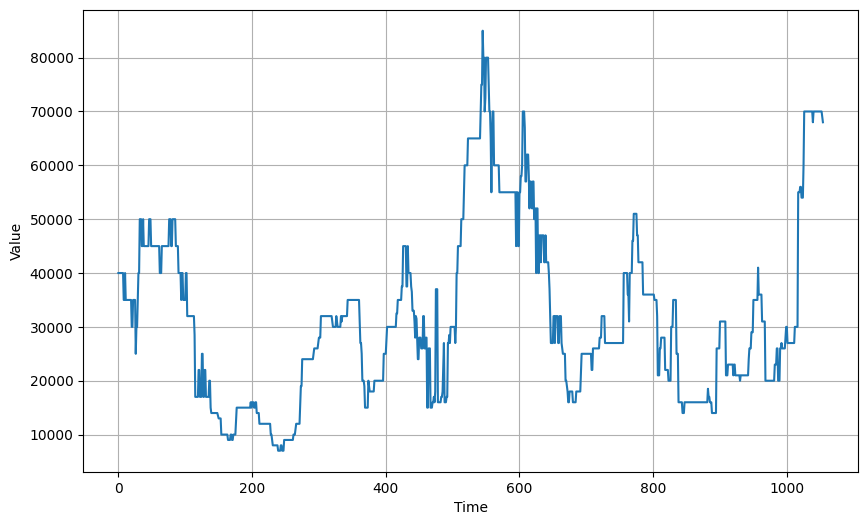

In [3]:
# Plot the results
plot_series(time, series)

In [5]:
# Define the split time
split_time = 800

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [6]:
# Parameters
window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [8]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [61]:
# Print shapes of feature and label
for window in dataset.take(1):
  print(f'shape of feature: {window[0].shape}')
  print(f'shape of label: {window[1].shape}')

shape of feature: (32, 60)
shape of label: (32,)


In [9]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 1e-4

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
steps = 200

EPOCHS = 50

history = model.fit(train_uni , epochs = EPOCHS, steps_per_epoch = steps ,
               validation_data = val_uni, validation_steps = 50)

Epoch 1/100
24/24 [==============================] - 9s 57ms/step - loss: 29336.0020 - mae: 29336.5020
Epoch 2/100
24/24 [==============================] - 2s 52ms/step - loss: 16626.7812 - mae: 16627.2812
Epoch 3/100
24/24 [==============================] - 1s 44ms/step - loss: 12965.5586 - mae: 12966.0586
Epoch 4/100
24/24 [==============================] - 1s 44ms/step - loss: 12975.8428 - mae: 12976.3428
Epoch 5/100
24/24 [==============================] - 1s 44ms/step - loss: 12961.2070 - mae: 12961.7070
Epoch 6/100
24/24 [==============================] - 1s 48ms/step - loss: 12978.9219 - mae: 12979.4219
Epoch 7/100
24/24 [==============================] - 1s 44ms/step - loss: 12963.7295 - mae: 12964.2295
Epoch 8/100
24/24 [==============================] - 1s 43ms/step - loss: 12960.3740 - mae: 12960.8740
Epoch 9/100
24/24 [==============================] - 1s 45ms/step - loss: 12976.6963 - mae: 12977.1963
Epoch 10/100
24/24 [==============================] - 1s 43ms/step - loss

In [52]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


24/24 [==============================] - 2s 22ms/step - loss: 10074.1221 - lr: 1.0000e-08
Epoch 2/100
24/24 [==============================] - 1s 19ms/step - loss: 10068.8252 - lr: 1.1220e-08
Epoch 3/100
24/24 [==============================] - 1s 18ms/step - loss: 10062.2080 - lr: 1.2589e-08
Epoch 4/100
24/24 [==============================] - 1s 19ms/step - loss: 10054.8477 - lr: 1.4125e-08
Epoch 5/100
24/24 [==============================] - 1s 19ms/step - loss: 10046.7666 - lr: 1.5849e-08
Epoch 6/100
24/24 [==============================] - 1s 21ms/step - loss: 10037.9590 - lr: 1.7783e-08
Epoch 7/100
24/24 [==============================] - 1s 19ms/step - loss: 10028.4199 - lr: 1.9953e-08
Epoch 8/100
24/24 [==============================] - 1s 19ms/step - loss: 10018.1572 - lr: 2.2387e-08
Epoch 9/100
24/24 [==============================] - 1s 19ms/step - loss: 10007.1816 - lr: 2.5119e-08
Epoch 10/100
24/24 [==============================] - 1s 23ms/step - loss: 9995.5020 - lr: 2.8

(1e-08, 0.001, 0.0, 40000.0)

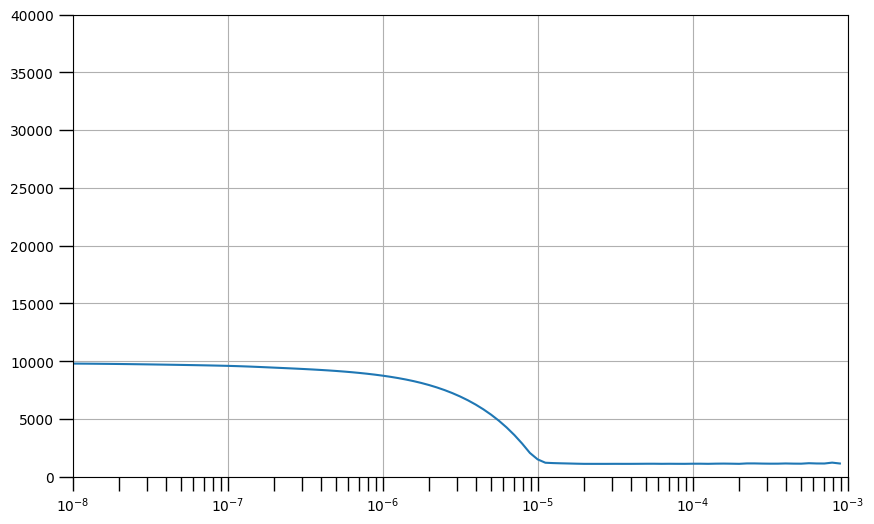

In [11]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 40000])

(1e-07, 0.0001, 0.0, 20000.0)

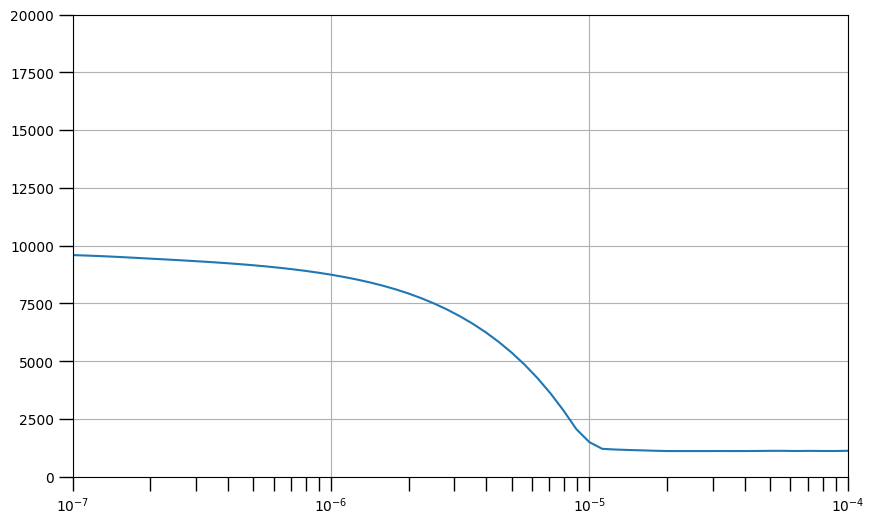

In [12]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-7, 1e-4, 0, 20000])

In [13]:
# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 1e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)

Epoch 1/100
25/25 [==============================] - 2s 9ms/step - loss: 9829.0996 - mae: 9829.5996
Epoch 2/100
25/25 [==============================] - 0s 10ms/step - loss: 9551.9746 - mae: 9552.4746
Epoch 3/100
25/25 [==============================] - 0s 10ms/step - loss: 9382.1602 - mae: 9382.6602
Epoch 4/100
25/25 [==============================] - 0s 11ms/step - loss: 9268.3760 - mae: 9268.8760
Epoch 5/100
25/25 [==============================] - 0s 11ms/step - loss: 9166.4434 - mae: 9166.9434
Epoch 6/100
25/25 [==============================] - 0s 8ms/step - loss: 9067.8760 - mae: 9068.3760
Epoch 7/100
25/25 [==============================] - 0s 9ms/step - loss: 8970.2637 - mae: 8970.7637
Epoch 8/100
25/25 [==============================] - 0s 8ms/step - loss: 8872.7754 - mae: 8873.2754
Epoch 9/100
25/25 [==============================] - 0s 7ms/step - loss: 8775.1055 - mae: 8775.6055
Epoch 10/100
25/25 [==============================] - 0s 8ms/step - loss: 8677.1377 - mae: 8677.

(1e-07, 0.0001, 0.0, 20000.0)

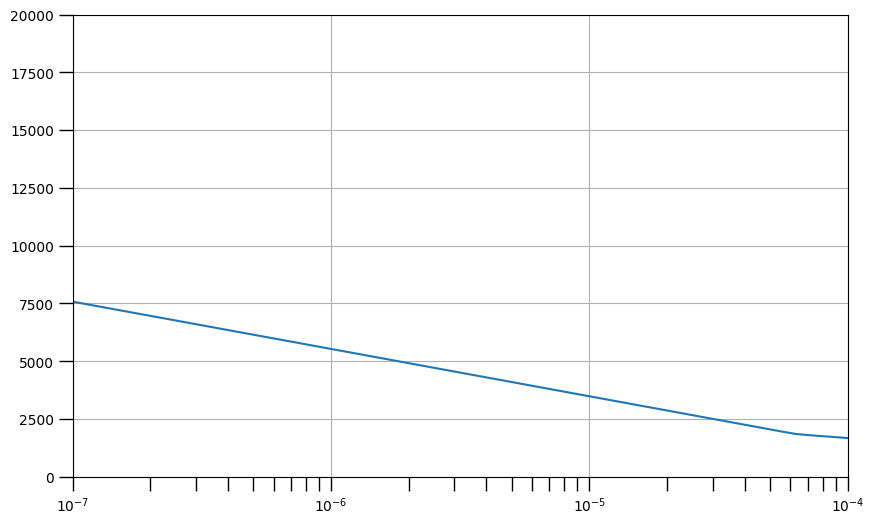

In [14]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-7, 1e-4, 0, 20000])

In [15]:
# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 1e-4

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=500)

Epoch 1/500
25/25 [==============================] - 2s 9ms/step - loss: 7543.7310 - mae: 7544.2310
Epoch 2/500
25/25 [==============================] - 0s 10ms/step - loss: 1752.3616 - mae: 1752.8616
Epoch 3/500
25/25 [==============================] - 0s 13ms/step - loss: 1162.8616 - mae: 1163.3616
Epoch 4/500
25/25 [==============================] - 0s 10ms/step - loss: 1130.1259 - mae: 1130.6256
Epoch 5/500
25/25 [==============================] - 0s 12ms/step - loss: 1111.2394 - mae: 1111.7394
Epoch 6/500
25/25 [==============================] - 0s 7ms/step - loss: 1115.2852 - mae: 1115.7850
Epoch 7/500
25/25 [==============================] - 0s 7ms/step - loss: 1111.3971 - mae: 1111.8971
Epoch 8/500
25/25 [==============================] - 0s 7ms/step - loss: 1110.8903 - mae: 1111.3903
Epoch 9/500
25/25 [==============================] - 0s 7ms/step - loss: 1112.7540 - mae: 1113.2532
Epoch 10/500
25/25 [==============================] - 0s 7ms/step - loss: 1115.5875 - mae: 1116.

In [54]:
# Initialize a list
forecast = []

# Reduce the original series
# forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))


1/1 [==============================] - 0s 27ms/step


In [55]:
model.predict(series[0:60][np.newaxis])

1/1 [==============================] - 0s 26ms/step


array([[9998.386]], dtype=float32)

In [64]:
# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()
for i in results:
    print(i)


# time = np.arange(len(series), dtype="float32")
# # # Plot the results
# plot_series(time,  results)

9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9998.386
9

In [18]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

8/8 [==============================] - 0s 7ms/step


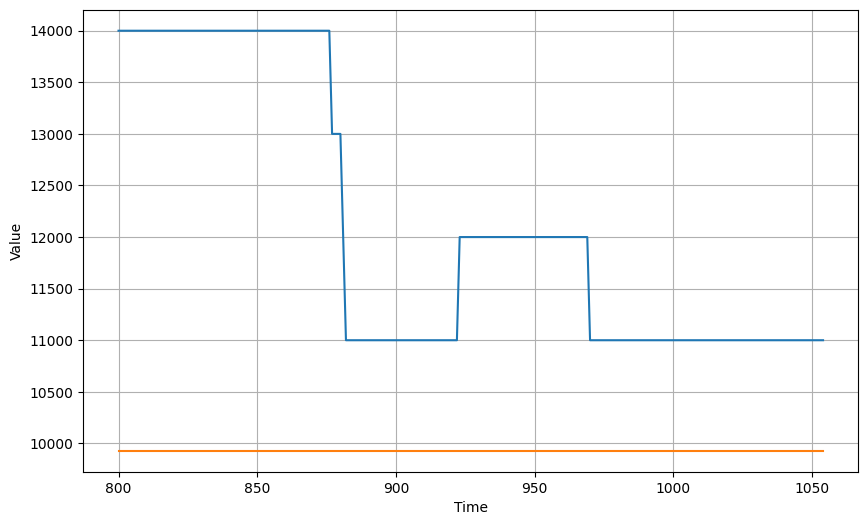

In [19]:
# Reduce the original series
forecast_series = series[split_time - window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))